### **League of Legends Machine Learning**

In [1]:
print('- a dive into machine learning using league of legends')
print('- goal is to predict total gold given champion stats at any given point in the game')
print('- exploring xgboost vs deep learning for tabular data')

- a dive into machine learning using league of legends
- goal is to predict total gold given champion stats at any given point in the game
- exploring xgboost vs deep learning for tabular data


### **Data Collection**

In [2]:
import requests
import json
import time
import pandas as pd
import numpy as np

In [3]:
# input: (platform and summoner name)
# output: PUUID
def getPUUIDByName(api_key, platform, summoner_name):
    endpoint = 'https://{platform}.api.riotgames.com/lol/summoner/v4/summoners/by-name/{summoner_name}'
    headers = {'X-Riot-Token': api_key}

    url = endpoint.format(platform=platform, summoner_name=summoner_name)
    response = requests.get(url, headers=headers)

    if response.status_code == 200:
        summoner_data = json.loads(response.text)
        puuid = summoner_data['puuid']
        print('PUUID for player {name} is {puuid}'.format(name=summoner_name, puuid=puuid))
        return puuid
    else:
        print(response.status_code)
        print('Failed to retrieve PUUID for player {name}'.format(name=summoner_name)) 

In [4]:
# input: (region, PUUID, match type, match count)
# output: last match count matches of match type
def getMatches(api_key, region, puuid, match_type, match_count):
    endpoint = 'https://{region}.api.riotgames.com/lol/match/v5/matches/by-puuid/{puuid}/ids?type={match_type}&start=0&count={match_count}'
    headers = {'X-Riot-Token': api_key}

    url = endpoint.format(region=region, puuid=puuid, match_type=match_type, match_count=match_count)
    response = requests.get(url, headers=headers)

    if response.status_code == 200:
        match_data = json.loads(response.text)
        print('{match_count} {match_type} matches for puuid {puuid} retrieved'.format(match_count=match_count, match_type=match_type, puuid=puuid))
        return match_data
    else:
        print(response.status_code)
        print('Failed to retrieve match data for player {puuid}'.format(puuid=puuid))
        return None

In [5]:
# input: (region, match id)
# output: match timeline json
def getMatchTimeline(api_key, region, match_id):
  endpoint = 'https://{region}.api.riotgames.com/lol/match/v5/matches/{match_id}/timeline'
  headers = {'X-Riot-Token': api_key}

  url = endpoint.format(region=region, match_id=match_id)
  response = requests.get(url, headers=headers)

  if response.status_code == 200:
      # appears to be a special case where there are no participant frames.
      # not sure of the exact cause. perhaps remakes or server issues.
      if response.json()['info']['frames'][0]['participantFrames'] is None:
          print('Error: Empty frames for match {match_id}'.format(match_id=match_id))
          return None
      else:
          print('Match timeline for match {match_id} retrieved'.format(match_id=match_id))
          return response.json()
  else:
      print(response.status_code)
      print('Failed to retrieve match timeline for match {id}'.format(id=match_id)) 

In [6]:
# input: match timeline json
# output: frame data as dataframe
def timelineToDF(match_timeline_json):
    match_time_line_data = pd.json_normalize(match_timeline_json)
    match_time_line_data.drop(['metadata.dataVersion', 'metadata.matchId', 'metadata.participants', 'info.frameInterval', 'info.gameId', 'info.participants'], axis=1)
    events_data = match_time_line_data['info.frames'].apply(pd.Series).stack().reset_index(level=1, drop=True).apply(pd.Series)
    frames_data = events_data['participantFrames'].apply(pd.Series).stack().reset_index(level=1, drop=True).apply(pd.Series)
    champion_stats_data = frames_data['championStats'].apply(pd.Series)
    damage_stats_data = frames_data['damageStats'].apply(pd.Series)
    position_data = frames_data['position'].apply(pd.Series)

    frames_data = pd.concat([
        frames_data.drop(['championStats', 'damageStats', 'position'], axis=1),
        champion_stats_data,
        damage_stats_data,
        position_data
    ], axis=1)
    return frames_data

In [7]:
# input: (platform, region, match_type, match_count, delay, summoner_name)
# output: list of unique match ids from the last match_count matches of match_type from summoner names
def uniqueMatches(api_key, platform, region, match_type, match_count, delay, summoner_names):
    all_matches = []
    for summoner_name in summoner_names:
        time.sleep(delay) # for api rate limits
        puuid = getPUUIDByName(api_key, platform, summoner_name)
        time.sleep(delay) # for api rate limits
        matches = getMatches(api_key, region, puuid, match_type, match_count)
        if matches:
          all_matches.extend(matches)
    return list(set(all_matches))

In [8]:
# input: (matches, delay)
# output: frame data as dataframe of all match ids in matches
def matchesToData(api_key, region, matches, delay):
    df = pd.DataFrame()
    for i in range(len(matches)):
        time.sleep(delay) # for api rate limits
        match_timeline_json = getMatchTimeline(api_key, region, matches[i])
        if match_timeline_json:
            frames_data = timelineToDF(match_timeline_json)
            df = pd.concat([df, frames_data], ignore_index=True)
        print(i,'matches processed')
    return df

In [9]:
# input: (matches, delay)
# output: frame data as dataframe of all match ids in matches
def matchesToDataWithFE(api_key, region, matches, delay):
    df = pd.DataFrame()
    for i in range(len(matches)):
        # time.sleep(delay) # for api rate limits
        match_timeline_json = getMatchTimeline(api_key, region, matches[i])
        if match_timeline_json:
            frames_data = timelineToDFWithFE(match_timeline_json)
            df = pd.concat([df, frames_data], ignore_index=True)
        print(i,'matches processed')
    return df

# input: match timeline json
# output: frame data as dataframe
def timelineToDFWithFE(match_timeline_json):
    match_time_line_data = pd.json_normalize(match_timeline_json)
    match_time_line_data.drop(['metadata.dataVersion', 'metadata.matchId', 'metadata.participants', 'info.frameInterval', 'info.gameId', 'info.participants'], axis=1)
    events_data = match_time_line_data['info.frames'].apply(pd.Series).stack().reset_index(level=1, drop=True).apply(pd.Series)
    frames_data = events_data['participantFrames'].apply(pd.Series).stack().reset_index(level=1, drop=True).apply(pd.Series)

    frames_data = pd.concat([
        frames_data.drop(['championStats', 'damageStats', 'position'], axis=1),
        frames_data['championStats'].apply(pd.Series),
        frames_data['damageStats'].apply(pd.Series),
        frames_data['position'].apply(pd.Series),
    ], axis=1)

    # adding distances
    distances = []
    for i in range(0, len(frames_data), 10):
        group = frames_data.iloc[i:i+10]
        for j in range(10):
            x = group.iloc[j]['x']
            y = group.iloc[j]['y']
            row_distances = [np.sqrt((x - group.iloc[k]['x'])**2 + (y - group.iloc[k]['y'])**2) for k in range(10)]
            distances.append(row_distances)
    distances_df = pd.DataFrame(distances, columns=[f'distance_to_{j+1}' for j in range(10)])
    frames_data = frames_data.reset_index(drop=True)    
    frames_data = pd.concat([frames_data, distances_df], axis=1)

    return frames_data

In [17]:
api_key = 'enter_api_key_here'
platform = 'na1'
region = 'americas'
match_type = 'ranked'
match_count = '100'
delay = 1.2 # for api rate limit
# summoner_names = ['dummyforerrors', 'twtv Gryffinn', 'Iuger', 'T0mio', 'DouyinTonyTop', 'TL Honda APA', 
#                   'Isles LFT', 'Isles LFT 2', 'PremadeOnlyParty', 'pwWX hc9999na', 
#                   '0 n a t', 'ttv rosethornlol', 'pwWX hc9999na', 'sup line', 'TheRealPhilip', 
#                   'WX laozhoudl', 'Topo', 'Solitaire', 'donb', 'Cody Sun', 'Breezyyy', 
#                   'pizzaman007', 'jimmykoi', 'Good Boi', 'bot line', 'C9 Zven', 
#                   'bigboichoi69', 'KingClueless', 'Samikin', 'Yuu13', 'tempbiekmgbbitcs', 
#                   'SwagTake', 'YoojungHukiriLee', 'faker god top', 'FLY VicLa', 'Cupic', 
#                   'Wxnt', 'ARMAO', 'Music101', 'rovex7', 'Bazz B', 'boats and logs', 'newjeansfan2003',
#                   'trance enjoyer', 'Eyla', 'Stunt', 'gg wtf', 'spooky fan 3', 'Pockus', 'Sophist Sage',
#                   'fidens', 'ttv warcyclone', 'ffman', 'readysetgo1', 'Pentaless', 'Sheiden',
#                   'Zyko', 'shochi', 'twtv wl4m', 'arrrrrrray', '375 Benchpress', 'Yung Fappy',
#                   'TL Honda Tempos', 'wx nzt020627', 'Haven666', 'Pobelter', 'twtv mystic77',
#                   'nalamango', 'callmebaby', 'PW NAtongtiandai', 'Leemo', 'rege', 'TTV AKASHI10',
#                   'zpy', '10April', 'My Dream LCS', 'Matcha Tamago', 'FinleyFionaBabli', 'Miky2',
#                   'm0neysigneric', 'AnazKr', '2 TTV Karhus', 'ASTROBOY99', 'dfgtredfg4', 'edalB FT',
#                   'PantsAreYouTube', 'fuwafuwaa', 'Wanfeng ouo', 'BLG F4N', 'HANXGAKU RANK 1', 'FATE999',
#                   'stargazer', 'Cotogod', 'issariu', 'kookykrook', 'yttrS', 'Armored Mawdad',
#                   'wx NAtongtiandai', 'Eclipse', 'SCARYJERRYY', 'Jauny12', 'qasdasweq', 'IS THAT FEEDABOI',
#                   'PastIsJustAGhost', 'Augustine', 'dlwlrma fan', 'Joggerss', 'Prizzmal', 'Denathor',
#                   '100 yukino', 'Redneck Pope555', 'Vx pangdahai911', 'Zev', 'Tactical0', 'lunacia',
#                   'niinim', 'TL Honda Bwipo', 'Mizli', 'Yoo Jonghyuk', 'Fanatiik', 'Sushee', 'FrosFores',
#                   'X V Z I', 'C9 Berzerker', 'Antihero', 'jamican banana', 'Tampico 2023', 'First Kyu',
#                   'TSM Chime', 'Fanthom', 'MySwordCrimson', 'You better work', 'The GnomeSlayer',
#                   'Allorim', 'Protos', 'PND 2', 'Mr Bluehat', 'Andoqs', 'insung', 'Pigeon Enjoyer',
#                   'T0OBY', 'chomaker', 'bxjjj', 'Airflash', 'Ariendel', 'ZED04', 'Tie am I', 'Phuemough',
#                   'da xi gua', 'Bibiswag', 'Endorfin', 'Marios', 'Dahyun x Twice', 'Jiang duo bao',
#                   'abigbroomstick', 'ChickenJo4', 'WildTurtle', 'c9 tomio', 'Wcc', 'Hub1012345']
# matches = uniqueMatches(api_key, platform, region, match_type, match_count, delay, summoner_names)

In [11]:
file_path = 'matches.json'

with open(file_path, "r") as file:
    matches = json.load(file)

In [12]:
len(matches)

8792

In [48]:
with open('matches.json', 'w') as file:
    json.dump(matches, file)

In [15]:
sections = [matches[i: i+1000] for i in range(0, len(matches), 1000)]

In [16]:
len(sections)
for section in sections:
    print(len(section))
# sections 0-8 -> df 0-8
print(len(sections[8]))

1000
1000
1000
1000
1000
1000
1000
1000
792
792


In [22]:
df8 = matchesToDataWithFE(api_key, region, sections[8], delay)
df8.to_csv('data8.csv', index=False)

Match timeline for match NA1_4657484606 retrieved
0 matches processed
Match timeline for match NA1_4641531924 retrieved
1 matches processed
Match timeline for match NA1_4653765161 retrieved
2 matches processed
Match timeline for match NA1_4647917720 retrieved
3 matches processed
Match timeline for match NA1_4664975584 retrieved
4 matches processed
Match timeline for match NA1_4639467506 retrieved
5 matches processed
Match timeline for match NA1_4654265350 retrieved
6 matches processed
Match timeline for match NA1_4594646805 retrieved
7 matches processed
Match timeline for match NA1_4649120938 retrieved
8 matches processed
Match timeline for match NA1_4664722035 retrieved
9 matches processed
Match timeline for match NA1_4655536841 retrieved
10 matches processed
Match timeline for match NA1_4621937043 retrieved
11 matches processed
Match timeline for match NA1_4660254584 retrieved
12 matches processed
Match timeline for match NA1_4667527718 retrieved
13 matches processed
Match timeline f

In [23]:
files = ['data0.csv', 'data1.csv', 'data2.csv', 'data3.csv', 'data4.csv', 'data5.csv', 'data6.csv', 'data7.csv', 'data8.csv']

dfs = []

for file in files:
    df = pd.read_csv(file)
    dfs.append(df)

combined_dfs = pd.concat(dfs)
combined_dfs.to_csv('data.csv', index=False)


In [45]:
# matchesToDataWithFE adds distance as a feature
# df = matchesToDataWithFE(api_key, region, matches, delay)

In [24]:
combined_dfs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2342050 entries, 0 to 207249
Data columns (total 58 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   currentGold                    int64  
 1   goldPerSecond                  int64  
 2   jungleMinionsKilled            int64  
 3   level                          int64  
 4   minionsKilled                  int64  
 5   participantId                  int64  
 6   timeEnemySpentControlled       int64  
 7   totalGold                      int64  
 8   xp                             int64  
 9   abilityHaste                   int64  
 10  abilityPower                   int64  
 11  armor                          int64  
 12  armorPen                       int64  
 13  armorPenPercent                int64  
 14  attackDamage                   int64  
 15  attackSpeed                    int64  
 16  bonusArmorPenPercent           int64  
 17  bonusMagicPenPercent           int64  
 18  ccR

In [ ]:
df.to_csv('data.csv', index=False)

### **Prepare Data**

In [28]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# frame_data = pd.read_csv('./data.csv')
frame_data = combined_dfs
print(frame_data.shape)
print(frame_data.columns)

exclude_cols = [f'distance_to_{i+1}' for i in range(10)] + ['x', 'y', 'totalGold', 'xp', 
                                                            'totalDamageDoneToChampions', 'goldPerSecond', 
                                                            'jungleMinionsKilled', 'currentGold', 'level', 
                                                            'minionsKilled', 'participantId', 
                                                            'timeEnemySpentControlled', 'magicDamageDone',
                                                            'magicDamageDoneToChampions', 'magicDamageTaken', 'physicalDamageDone',
                                                            'physicalDamageDoneToChampions', 'physicalDamageTaken',
                                                            'totalDamageDone', 'totalDamageTaken', 'trueDamageDone',
                                                            'trueDamageDoneToChampions', 'trueDamageTaken']
X = frame_data.drop(exclude_cols, axis=1)

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
y = frame_data.totalGold

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state = 42)

(2342050, 58)
Index(['currentGold', 'goldPerSecond', 'jungleMinionsKilled', 'level',
       'minionsKilled', 'participantId', 'timeEnemySpentControlled',
       'totalGold', 'xp', 'abilityHaste', 'abilityPower', 'armor', 'armorPen',
       'armorPenPercent', 'attackDamage', 'attackSpeed',
       'bonusArmorPenPercent', 'bonusMagicPenPercent', 'ccReduction',
       'cooldownReduction', 'health', 'healthMax', 'healthRegen', 'lifesteal',
       'magicPen', 'magicPenPercent', 'magicResist', 'movementSpeed',
       'omnivamp', 'physicalVamp', 'power', 'powerMax', 'powerRegen',
       'spellVamp', 'magicDamageDone', 'magicDamageDoneToChampions',
       'magicDamageTaken', 'physicalDamageDone',
       'physicalDamageDoneToChampions', 'physicalDamageTaken',
       'totalDamageDone', 'totalDamageDoneToChampions', 'totalDamageTaken',
       'trueDamageDone', 'trueDamageDoneToChampions', 'trueDamageTaken', 'x',
       'y', 'distance_to_1', 'distance_to_2', 'distance_to_3', 'distance_to_4',
      

In [ ]:
X.columns

Index(['abilityHaste', 'abilityPower', 'armor', 'armorPen', 'armorPenPercent',
       'attackDamage', 'attackSpeed', 'bonusArmorPenPercent',
       'bonusMagicPenPercent', 'ccReduction', 'cooldownReduction', 'health',
       'healthMax', 'healthRegen', 'lifesteal', 'magicPen', 'magicPenPercent',
       'magicResist', 'movementSpeed', 'omnivamp', 'physicalVamp', 'power',
       'powerMax', 'powerRegen', 'spellVamp'],
      dtype='object')

### **Train XGBoost Model**

In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

# default n_estimators=100, learning_rate=0.1
model = XGBRegressor(n_jobs=-1, random_state=42)

model.fit(X_train, y_train,
          early_stopping_rounds=10, 
          eval_set=[(X_test, y_test)],
          verbose=False)

xgb_preds = model.predict(X_test)

score = mean_absolute_error(y_test, xgb_preds)
print('MAE:', score)

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


MAE: 426.09102505061475


### **Hyperparameter Tuning with Grid Search**

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 500],
    'learning_rate': [0.1, 0.3]
}

xgb = XGBRegressor(random_state=42)

grid = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='neg_mean_absolute_error', n_jobs=-1, cv=3)
grid.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=42, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.3],
                         'n_estimators': [100, 500]},
             scoring='neg_mean_absolute_error')

In [ ]:
grid.best_params_

{'learning_rate': 0.3, 'n_estimators': 500}

In [ ]:
best_estimator = grid.best_estimator_
best_xgb_preds = best_estimator.predict(X_test)

score = mean_absolute_error(y_test, best_xgb_preds)
print('MAE:', score)

MAE: 373.98448720432464


In [29]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

model = XGBRegressor(learning_rate=0.3, n_estimators=500, n_jobs=-1, random_state=42)

model.fit(X_train, y_train,
          early_stopping_rounds=10, 
          eval_set=[(X_test, y_test)],
          verbose=False)

xgb_preds = model.predict(X_test)

score = mean_absolute_error(y_test, xgb_preds)
print('MAE:', score)

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


MAE: 383.0562020865684


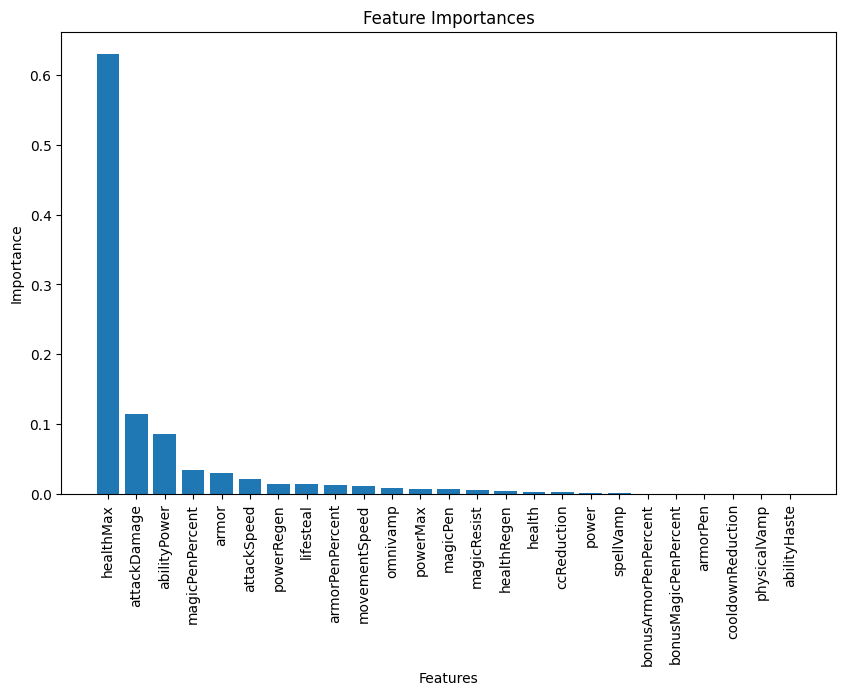

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# importances = best_estimator.feature_importances_
importances = model.feature_importances_
feature_names = X.columns

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(X_train.shape[1]), importances[indices])
plt.xticks(range(X_train.shape[1]), feature_names[indices], rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.show()

### **Train Deep Learning Model**

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
early_stopping = EarlyStopping(
    min_delta=0.01,
    patience=5,
    restore_best_weights=True,
)

model = keras.Sequential([
    layers.Dense(512, activation='relu', input_shape=[len(list(X.columns))]),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(1),
])

model.compile(
    optimizer='adam',
    loss='mae',
)

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=256,
    epochs=100,
    callbacks=[early_stopping],
)

Epoch 1/100
714/714 [==============================] - 32s 42ms/step - loss: 4955.9531 - val_loss: 4167.8193
Epoch 2/100
714/714 [==============================] - 30s 42ms/step - loss: 3670.9692 - val_loss: 2561.0723
Epoch 3/100
714/714 [==============================] - 31s 43ms/step - loss: 1584.6383 - val_loss: 817.9481
Epoch 4/100
714/714 [==============================] - 30s 42ms/step - loss: 662.4241 - val_loss: 542.3116
Epoch 5/100
714/714 [==============================] - 30s 41ms/step - loss: 632.0405 - val_loss: 560.7869
Epoch 6/100
714/714 [==============================] - 30s 41ms/step - loss: 621.2794 - val_loss: 522.7128
Epoch 7/100
714/714 [==============================] - 31s 43ms/step - loss: 614.0981 - val_loss: 533.5526
Epoch 8/100
714/714 [==============================] - 30s 42ms/step - loss: 608.5247 - val_loss: 527.1114
Epoch 9/100
714/714 [==============================] - 30s 42ms/step - loss: 604.9917 - val_loss: 506.7570
Epoch 10/100
714/714 [==========

In [ ]:
score = model.evaluate(X_test, y_test)
print('MAE:',score)

1428/1428 [==============================] - 7s 5ms/step - loss: 462.2295
MAE: 462.2294616699219


Minimum Validation Loss: 462.2293


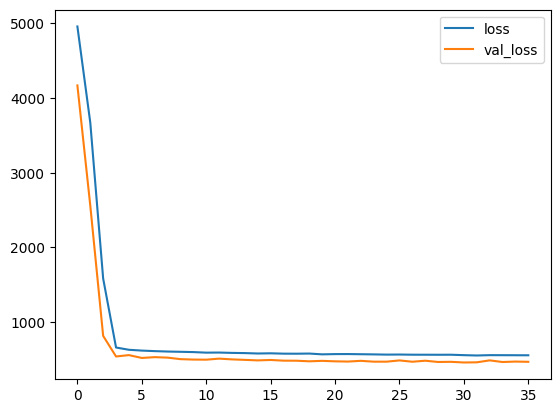

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
print(("Minimum Validation Loss: {:0.4f}").format(history_df['val_loss'].min()))

Minimum Validation Loss: 462.2293


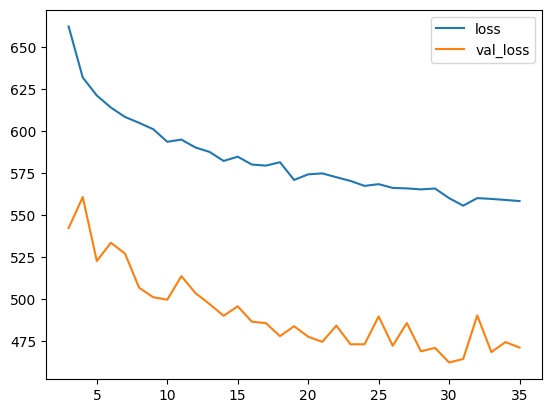

In [ ]:
history_df.loc[3:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));